# Data understanding: 
#### Please upvote, comment, and revisit; I am still improving this kernel notebook.

# Objective:

Knowing the objective of a featured coding competition:

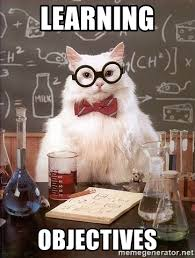

Credit to @massoud for his clear [baseline kernel](https://www.kaggle.com/mhviraf/a-baseline-for-dsb-2019). 


Be clear the ```installation_id``` is unique. Now, group all the rows together with same ```installation_id```.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import plotly.express as px
import plotly.graph_objects as go
import json
import seaborn as sns

#### Load data

In [ ]:
print(os.listdir('../input/data-science-bowl-2019/'))

In [ ]:
df_train = pd.read_csv("../input/data-science-bowl-2019/train.csv")
df_train_labels = pd.read_csv("../input/data-science-bowl-2019/train_labels.csv")
df_specs = pd.read_csv("../input/data-science-bowl-2019/specs.csv")
df_test = pd.read_csv("../input/data-science-bowl-2019/test.csv")

In [ ]:
print("Shape of training data:{}".format(df_train.shape))
print("Shape of training labels data:{}".format(df_train_labels.shape))
print("Shape of specs data:{}".format(df_specs.shape))
print("Shape of test data:{}".format(df_test.shape))

How I found the objective of this competition?
* list the unique ```installation_id``` in the test dataset.
* Select a random ```installation_id```, and do a head and tail operation to see the entires.

### Objective description:
Under ```type``` column, last entry is ```Assessment```, which one needs to predict based on the previous sequence of activities ```type``` carried out by a kind on a device. 

Take ```installation_id``` of 1st row (i.e. 0001e90f) and group the rows in a new dataframe. This will help in tracking sequence of activities a child carried out on that device.  

In [ ]:
df_test.installation_id.unique()

In [ ]:
df_test.query('installation_id=="0de6863d"').head(5)

In [ ]:
df_test.query('installation_id=="0de6863d"').tail(5)

Let us explore each table i.e. train, train_labels, specs, and test.

### What is in the train data?

In [ ]:
print(df_train.columns)
print(len(df_train.columns))

In [ ]:
df_train.head(3)

# Data preparation

As a part of competition, based on our understanding of train, test, specs, and train_labels data, let us join the train and specs to get comprehensive train_data. In addition, join test and specs to get comprehensive comprehensive test_data. 

We have to decide which 'join' strategy to use:
* Take the union of them all, join='outer'. This is the default option as it results in zero information loss.
* Take the intersection, join='inner'.

Here, we choose to take \union of df_train and df_specs, so that we don't loose any information as shown below.

### Joining train and specs datasets

In [ ]:
#joing train and specs datafrmae to get train_data.
#result = pd.concat([df_train, df_specs], axis=1, sort=False)

#result = pd.merge(df_train, df_specs, how='outer', on='event_id', left_on=None, right_on=None,
#         left_index=False, right_index=False, sort=False,
#         suffixes=('_x', '_y'), copy=True, indicator=False,
#         validate=None)

Good, done and dusted, seems we have reduced 2 rows, which were containing null value entries. 

### Joining test and specs datasets

In [ ]:
#result_test = pd.merge(df_test, df_specs, how='outer', on='event_id', left_on=None, right_on=None,
#         left_index=False, right_index=False, sort=False,
#         suffixes=('_x', '_y'), copy=True, indicator=False,
#         validate=None)
#result_test.head()

## Actual data understanding and data prepration part

Below is a helper function to check missing values and data type. It is taken from @gabriel's kernel here ([source kernel](https://www.kaggle.com/gpreda/2019-data-science-bowl-eda)).  

In [ ]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [ ]:
missing_data(df_train)

In [ ]:
missing_data(df_test)

In [ ]:
missing_data(df_specs)

In [ ]:
missing_data(df_train_labels)

#### Unique value check

Unique value in df_train|

In [ ]:
for col in df_train.columns:
    print("Column name:", col)
    print("Unique values--->",df_train[col].nunique())

Unique value in df_train_label

In [ ]:
for col in df_train_labels.columns:
    print("Column Name:", col)
    print("Unique values--->", df_train_labels[col].nunique())

Unique values in specs dataset

In [ ]:
for col in df_specs.columns:
    print("Column Name:", col)
    print("Unique values--->",df_specs[col].nunique())

Unique test values

In [ ]:
for col in df_test.columns:
    print("Column Name:", col)
    print("Unique values--->",df_test[col].nunique())

**Finding:**
Hmm.. event_id column is important while joining the tables. We can see two table joins:
1. Join df_train and df_train_labels,
2. Join the resulting table from 1st step with df_specs, and
3. Join the df_test and df_specs,

df_train has 384 unique event_ids, while df_test has 365 event_ids, and df_specs has 386 unique event_ids. 

Learning: Extract Json format 


In [ ]:
%%time
#extracted_event_data = pd.io.json.json_normalize(df_train.event_data.apply(json.loads))
#extracted_event_data = pd.io.json.json_normalize(train_df.event_data.apply(json.loads))

In [ ]:
df_train_labels.columns

In [ ]:
df_train_labels.head()

Accuracy_group is our target feature in this competition. Let us see it distribution. 

In [ ]:
temp_accuracy_group = df_train_labels.accuracy_group

#sns.barplot(temp_accuracy_group.index, temp_accuracy_group)

In [ ]:
df_test.columns

We will need all the columns present in the test.csv to be present the final train dataset for training and predicting. Let us make a col name array which would be easy to store and call required columns

In [ ]:
min_viable_col = ['event_id', 'game_session', 'timestamp', 'event_data',
       'installation_id', 'event_count', 'event_code', 'game_time', 'title',
       'type', 'world']

In [ ]:
train_data = df_train[min_viable_col]
train_data.columns

Let us drop a difficult to process column for now i.e. 'event_data'. This column has important information about nature of game-play by each child, however, it is in JSON format and difficult to process. For the baseline model, we will not use this column for now. Let us drop 'event_data' from train and test data.

In [ ]:
train_data.drop(['event_data'], axis=1, inplace = True)
df_test.drop(['event_data'], axis=1, inplace= True)

In [ ]:
train_data.head(10)

In [ ]:
df_test.head(10)

## Time feature

Below snippet of code is directly taken from @shahules768 kernel [here](https://www.kaggle.com/shahules/xgboost-feature-selection-dsbowl). Added a line of code to drop the original timestamp after extracting month, hour, year, day of week, and week of year.

In [ ]:
def extract_time_features(df):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['month'] = df['timestamp'].dt.month
    df['hour'] = df['timestamp'].dt.hour
    df['year'] = df['timestamp'].dt.year
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['weekofyear'] = df['timestamp'].dt.weekofyear
    df.drop(['timestamp'], axis=1, inplace=True)
    return df

In [ ]:
train_data.shape, df_test.shape

In [ ]:
train_tmp = extract_time_features(train_data)

In [ ]:
test_tmp = extract_time_features(df_test)

In [ ]:
train_tmp.head()

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#sns.barplot(x="month", y="world", data=train_tmp)

fig, ax =plt.subplots(1, 2, figsize=(12,8))
sns.countplot(x="world",ax=ax[0], data=train_tmp)
sns.countplot(x="world", ax=ax[1], data=df_test)
fig.show()

In [ ]:
fig, ax =plt.subplots(1, 2, figsize=(12,8))
sns.countplot(x="type",ax=ax[0], data=train_tmp)
sns.countplot(x="type", ax=ax[1], data=df_test)
fig.show()

In [ ]:
fig, ax =plt.subplots(1, 2, figsize=(18,12))
chart1 = sns.countplot(x="title",ax=ax[0], data=train_tmp)
chart1.set_xticklabels(chart1.get_xticklabels(), rotation=90)
chart2 = sns.countplot(x="title", ax=ax[1], data=df_test)
chart2.set_xticklabels(chart2.get_xticklabels(), rotation=90)
fig.show()

In [ ]:
fig, ax =plt.subplots(1, 2, figsize=(12,8))
sns.countplot(x="month",ax=ax[0], data=train_tmp)
sns.countplot(x="month", ax=ax[1], data=df_test)
fig.show()

In [ ]:
fig, ax =plt.subplots(1, 2, figsize=(12,8))
sns.countplot(x="year",ax=ax[0], data=train_tmp)
sns.countplot(x="year", ax=ax[1], data=df_test)
fig.show()

In [ ]:
fig, ax =plt.subplots(1, 2, figsize=(12,8))
sns.countplot(x="hour",ax=ax[0], data=train_tmp)
sns.countplot(x="hour", ax=ax[1], data=df_test)
fig.show()

In [ ]:
fig, ax =plt.subplots(1, 2, figsize=(12,8))
sns.countplot(x="dayofweek",ax=ax[0], data=train_tmp)
sns.countplot(x="dayofweek", ax=ax[1], data=df_test)
fig.show()

In [ ]:
fig, ax =plt.subplots(1, 2, figsize=(12,8))
sns.countplot(x="weekofyear",ax=ax[0], data=train_tmp)
sns.countplot(x="weekofyear", ax=ax[1], data=df_test)
fig.show()

In [ ]:
train_tmp.head()

In [ ]:
test_tmp.head()

In [ ]:
train_tmp.shape, test_tmp.shape

Let us add labels from train_label. But how?

In [ ]:
df_train_labels.head()

In [ ]:
df_train_labels.shape

In [ ]:
len(df_train_labels.game_session.unique())